In [1]:
##Downloading dataset of titanic from kaggle(a dataset from github repo)
##https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv
###https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv

In [34]:
###Importing required lib to perform analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##loading the train and test dataset to a dataframe
data_train = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/train.csv')
data_test = pd.read_csv('https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv')

##Checking out sample data loaded into dataframe
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
123,124,1,2,"Webber, Miss. Susan",female,32.5,0,0,27267,13.00,E101,S
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.55,B38,S
694,695,0,1,"Weir, Col. John",male,60.0,0,0,113800,26.55,NaN,S


In [35]:
##Checking out the first five values from dataframe
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


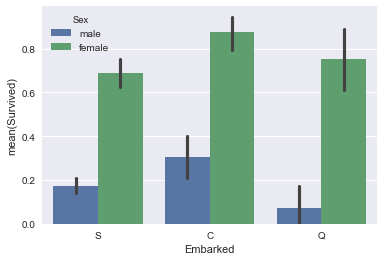

In [36]:
###trying out categorial visualization

sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

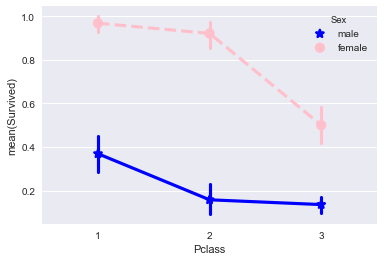

In [37]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

Transforming Features
Aside from 'Sex', the 'Age' feature is second in importance. To avoid overfitting, I'm grouping people into logical human age groups.
Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, let's slice it off.
Fare is another continuous value that should be simplified. I ran data_train.Fare.describe() to get the distribution of the feature, then placed them into quartile bins accordingly.
Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name and name prefix (Mr. Mrs. Etc.), then appended them as their own features.
Lastly, drop useless features. (Ticket and Name)

In [38]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df 
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


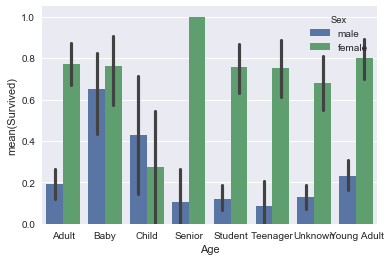

In [39]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

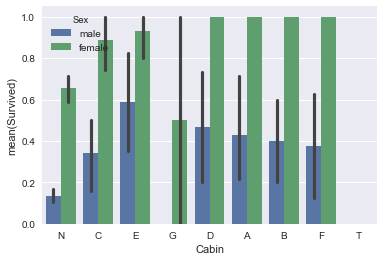

In [40]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

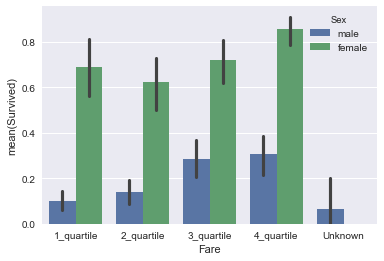

In [41]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

Some Final Encoding
The last part of the preprocessing phase is to normalize labels. The LabelEncoder in Scikit-learn will convert each unique string value into a number, making out data more flexible for various algorithms.

The result is a table of numbers that looks scary to humans, but beautiful to machines.

In [33]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()

TypeError: '>' not supported between instances of 'int' and 'str'

In [30]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [31]:
X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 151 to 595
Data columns (total 9 columns):
Pclass        712 non-null int64
Sex           712 non-null int64
Age           712 non-null category
SibSp         712 non-null int64
Parch         712 non-null int64
Fare          712 non-null int64
Cabin         712 non-null int64
Lname         712 non-null int64
NamePrefix    712 non-null int64
dtypes: category(1), int64(8)
memory usage: 51.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 727 to 829
Data columns (total 9 columns):
Pclass        179 non-null int64
Sex           179 non-null int64
Age           179 non-null category
SibSp         179 non-null int64
Parch         179 non-null int64
Fare          179 non-null int64
Cabin         179 non-null int64
Lname         179 non-null int64
NamePrefix    179 non-null int64
dtypes: category(1), int64(8)
memory usage: 13.1 KB


In [19]:
y_all.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

grid_obj

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
clf

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=6, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [22]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.787709497207


In [23]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.7666666666666667
Fold 2 accuracy: 0.8202247191011236
Fold 3 accuracy: 0.7865168539325843
Fold 4 accuracy: 0.8089887640449438
Fold 5 accuracy: 0.8202247191011236
Fold 6 accuracy: 0.7640449438202247
Fold 7 accuracy: 0.7640449438202247
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8764044943820225
Fold 10 accuracy: 0.8202247191011236
Mean Accuracy: 0.8025093632958802


C:\Users\venka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [42]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
acc_gaussian = round(accuracy_score(y_pred, y_test) * 100, 2)
print(acc_gaussian)

ValueError: could not convert string to float: 'Unknown'